# Satellite Image Analysis Challenge

## Task: Image Segmentation

In [1]:
import os
import copy

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sentinelhub import SHConfig, MimeType, CRS, BBox, SentinelHubRequest, DataCollection, bbox_to_dimensions

### Loading Data

In [2]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [3]:
data_folder = './sentinelhub_data/'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

In [4]:
aoi_coords_wgs84 = [28.5164960506072, 65.5625905564034, 28.8476328224876, 65.6486750602434]

In [5]:
resolution = 16
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: width = {aoi_size[0]} and height = {aoi_size[1]} pixels')

Image shape at 16 m resolution: width = 937 and height = 625 pixels


In [6]:
evalscript_allBands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 12,
                sampleType: "INT16"
            }
        };
    }

    function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
        outputMetadata.userData = { "norm_factor":  inputMetadata.normalizationFactor }
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B11,
                sample.B12];
    }
"""

request_allBands_multitype = SentinelHubRequest(
    data_folder=data_folder,
    evalscript=evalscript_allBands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2020-06-01', '2020-07-30'),
            mosaicking_order='leastCC',
            upsampling='BICUBIC',
            downsampling='BICUBIC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
        SentinelHubRequest.output_response('userdata', MimeType.JSON)
    ],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config
)

In [7]:
save_data=False
allBands_multitype_response = request_allBands_multitype.get_data(save_data=save_data)

In [8]:
if (save_data):
    print(f'The output directory has been created and a tiff file with all 12 bands was saved into the following structure:\n')

    for folder, _, filenames in os.walk(request_allBands_multitype.data_folder):
        for filename in filenames:
            print(os.path.join(folder, filename))

In [9]:
multi_data = allBands_multitype_response[0]
multi_data.keys()

dict_keys(['default.tif', 'userdata.json'])

In [10]:
data = multi_data['default.tif']

print(f'- Downloaded data')
print(f'    Data type: {data.dtype}')
print(f'    Data shape: {data.shape}')
print(f'    Max = {np.max(data)}, Min = {np.min(data)}')

norm_factor = multi_data['userdata.json']['norm_factor']
data = data * norm_factor

print(f'\n- Transformed data')
print(f'    Data type: {data.dtype}')
print(f'    Data shape: {data.shape}')
print(f'    Max = {np.max(data)}, Min = {np.min(data)}')

- Downloaded data
    Data type: uint16
    Data shape: (625, 937, 12)
    Max = 6135, Min = 1

- Transformed data
    Data type: float64
    Data shape: (625, 937, 12)
    Max = 0.6135, Min = 0.0001


### Image Processing

The image processing starts with the computation of the NDVI index, as it provides valuable information on vegetation.

In [11]:
numerator = data[:,:,7] - data[:,:,3]
denominator = data[:,:,7] + data[:,:,3] + 0.000000001
ndvi = numerator / denominator

print(f'- NDVI channel')
print(f'    Max = {np.max(ndvi):.4f}, Mean = {np.mean(ndvi):.4f}, Median = {np.median(ndvi):.4f}, Min = {np.min(ndvi):.4f}')

data = np.dstack([data, ndvi])

print(f'\n- Augmented data')
print(f'    Data type: {data.dtype}')
print(f'    Data shape: {data.shape}')

- NDVI channel
    Max = 0.9919, Mean = 0.5928, Median = 0.6694, Min = -0.9780

- Augmented data
    Data type: float64
    Data shape: (625, 937, 13)


In [12]:
print(f'- Basic statistics:')
bands = ['B01',"B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12", "NDVI"]
for counter, band in enumerate(bands):
    tmp = data[:,:,counter]
    print(f'    {band}: Max = {np.max(tmp):.4f}, Mean = {np.mean(tmp):.4f}, Median = {np.median(tmp):.4f}, Min = {np.min(tmp):.4f}')

- Basic statistics:
    B01: Max = 0.0778, Mean = 0.0131, Median = 0.0123, Min = 0.0001
    B02: Max = 0.1943, Mean = 0.0250, Median = 0.0231, Min = 0.0001
    B03: Max = 0.2137, Mean = 0.0416, Median = 0.0408, Min = 0.0001
    B04: Max = 0.2529, Mean = 0.0389, Median = 0.0331, Min = 0.0001
    B05: Max = 0.2549, Mean = 0.0808, Median = 0.0759, Min = 0.0001
    B06: Max = 0.4159, Mean = 0.1479, Median = 0.1537, Min = 0.0001
    B07: Max = 0.5086, Mean = 0.1698, Median = 0.1763, Min = 0.0001
    B08: Max = 0.6135, Mean = 0.1869, Median = 0.1926, Min = 0.0001
    B8A: Max = 0.5259, Mean = 0.1915, Median = 0.1975, Min = 0.0001
    B09: Max = 0.4604, Mean = 0.1940, Median = 0.2006, Min = 0.0001
    B11: Max = 0.4021, Mean = 0.1475, Median = 0.1510, Min = 0.0001
    B12: Max = 0.3767, Mean = 0.0862, Median = 0.0855, Min = 0.0001
    NDVI: Max = 0.9919, Mean = 0.5928, Median = 0.6694, Min = -0.9780


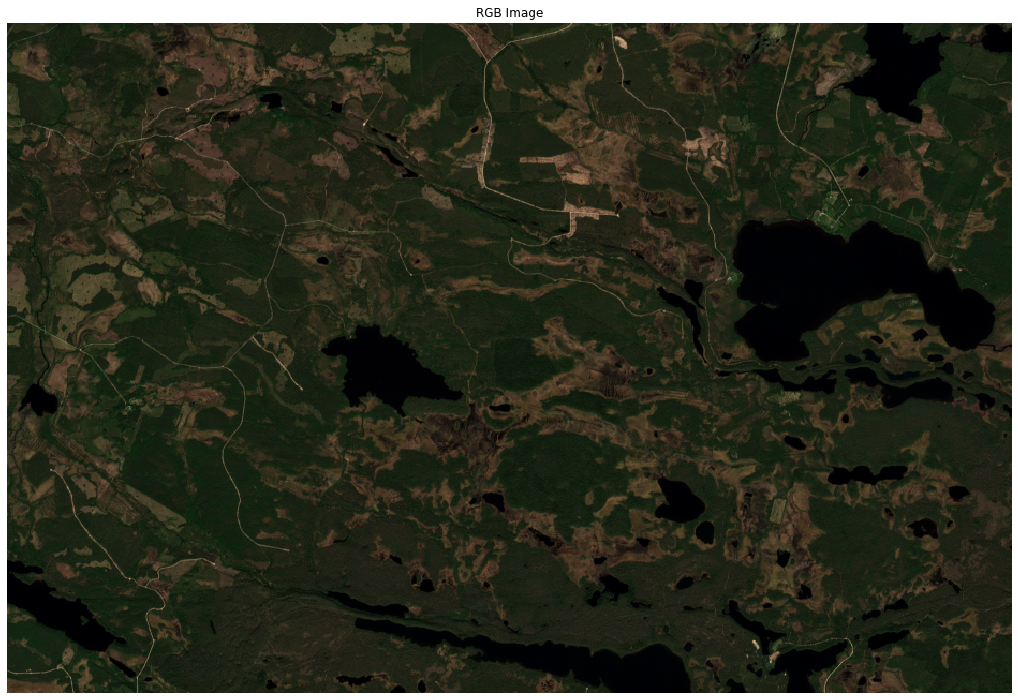

In [13]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(18, 14))

_ = ax0.imshow(np.clip(data[:,:, (3,2,1)]*3.5, a_min=0, a_max=1), interpolation='none')
_ = ax0.set_title('RGB Image')
_ = ax0.axis('off')

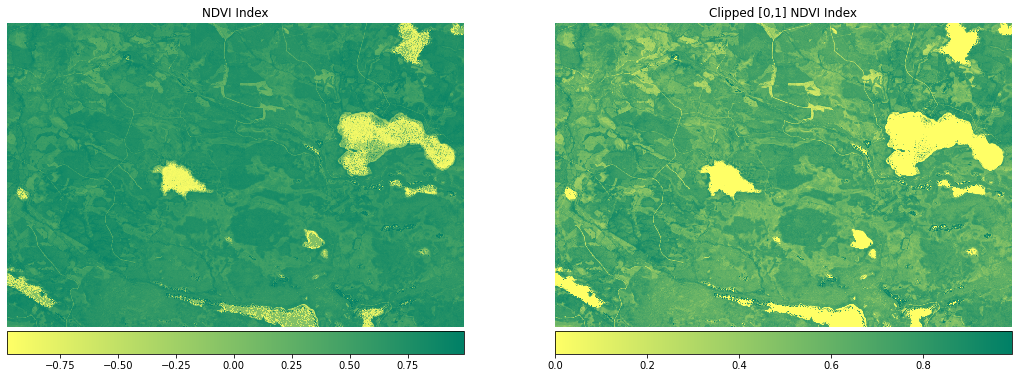

In [14]:
ndvi_norm = np.clip(a=data[:,:,-1], a_min=0, a_max=1.0, dtype=np.float64)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 14))

implot0 = ax0.imshow(data[:,:,-1], interpolation='none', cmap=cm.summer_r)
_ = ax0.set_title('NDVI Index')
_ = ax0.axis('off')
_ = fig.colorbar(implot0, ax=ax0, orientation='horizontal', pad=0.005)

implot1 = ax1.imshow(ndvi_norm, interpolation='none', cmap=cm.summer_r)
_ = ax1.set_title('Clipped [0,1] NDVI Index')
_ = ax1.axis('off')
_ = fig.colorbar(implot1, ax=ax1, orientation='horizontal', pad=0.005)

From the images above, a reasonably good contrast (i.e., separation) between the different classes is achieved using the clipped NDVI index image. However, it is possible to observe moderate to high 'reflectance' values within the boundaries of lake regions. A reasonable explanation supporting this observations is the presence of algae on the water surface during summer in Finland. To avoid misclassifying pixels potentially corresponding to algae as forest, a mask indicating water regions should be created. All bands are inspected to identify one that offers good water contrast. From the following figure, Band 11 (SWIR) is chosen for the described purpose. Also, it is possible to notice that B01 and B09 images are a bit blurred due to the interpolation from 60m resolution down to 16m. 

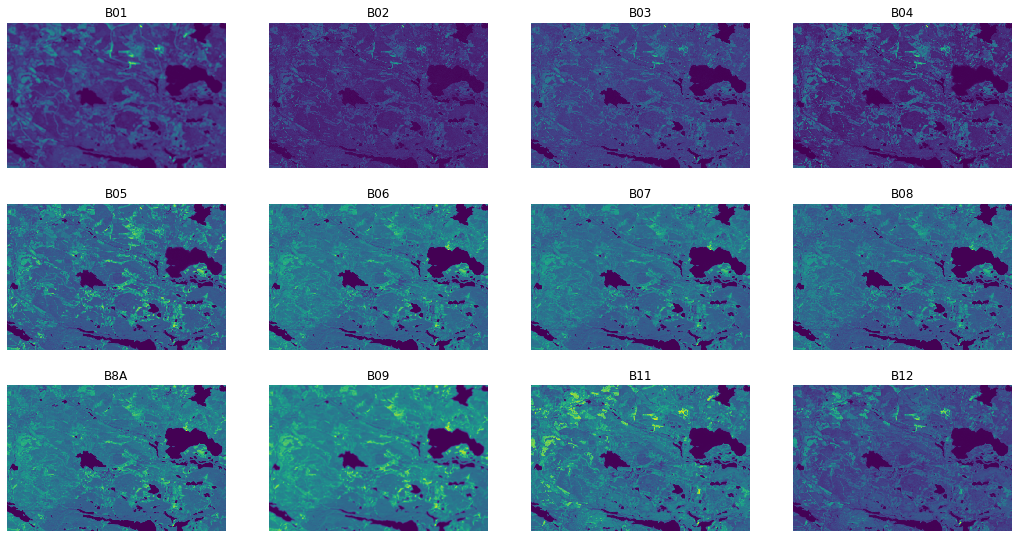

In [15]:

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 10))
for counter in range(len(bands)-1):
    _ = axs.flat[counter].imshow(data[:,:,counter], interpolation='none')
    _ = axs.flat[counter].set_title(f'{bands[counter]}')
    _ = axs.flat[counter].axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=0.)
plt.tight_layout
plt.show()

In [16]:
b11_norm = data[:,:,10] / np.max(data[:,:,10])

water_mask = np.zeros(shape=(data.shape[0],data.shape[1]))
water_mask[b11_norm<0.05]=1

print(f'\n- Normalized B11')
print(f'    Data type: {b11_norm.dtype}')
print(f'    Data shape: {b11_norm.shape}')
print(f'    Max = {np.max(b11_norm):.4f}, Mean = {np.mean(b11_norm):.4f}, Median = {np.median(b11_norm):.4f}, Min = {np.min(b11_norm):.4f}')


- Normalized B11
    Data type: float64
    Data shape: (625, 937)
    Max = 1.0000, Mean = 0.3667, Median = 0.3755, Min = 0.0002


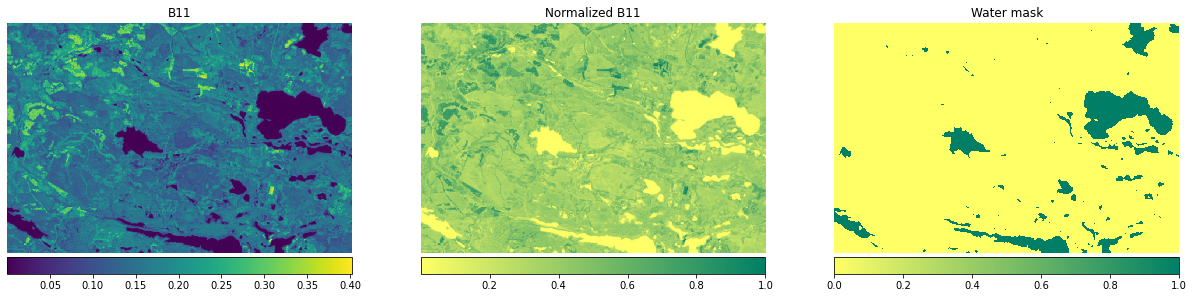

In [17]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(21, 14))

implot0 = ax0.imshow(data[:,:,10], interpolation='none')
_ = ax0.set_title('B11')
_ = ax0.axis('off')
_ = fig.colorbar(implot0, ax=ax0, orientation='horizontal', pad=0.005)

implot1 = ax1.imshow(b11_norm, interpolation='none', cmap=cm.summer_r)
_ = ax1.set_title('Normalized B11')
_ = ax1.axis('off')
_ = fig.colorbar(implot1, ax=ax1, orientation='horizontal', pad=0.005)

implot2 = ax2.imshow(water_mask, interpolation='none', cmap=cm.summer_r)
_ = ax2.set_title('Water mask')
_ = ax2.axis('off')
_ = fig.colorbar(implot2, ax=ax2, orientation='horizontal', pad=0.005)

The regions corresponding to lakes can be removed from the clipped NDVI index image with the Water mask. As it can be observed through the following image, the contrast offered by the NDVI index across the different classes is kept while pixels within boundaries of lake regions are corrected to account for the potential algae issue.

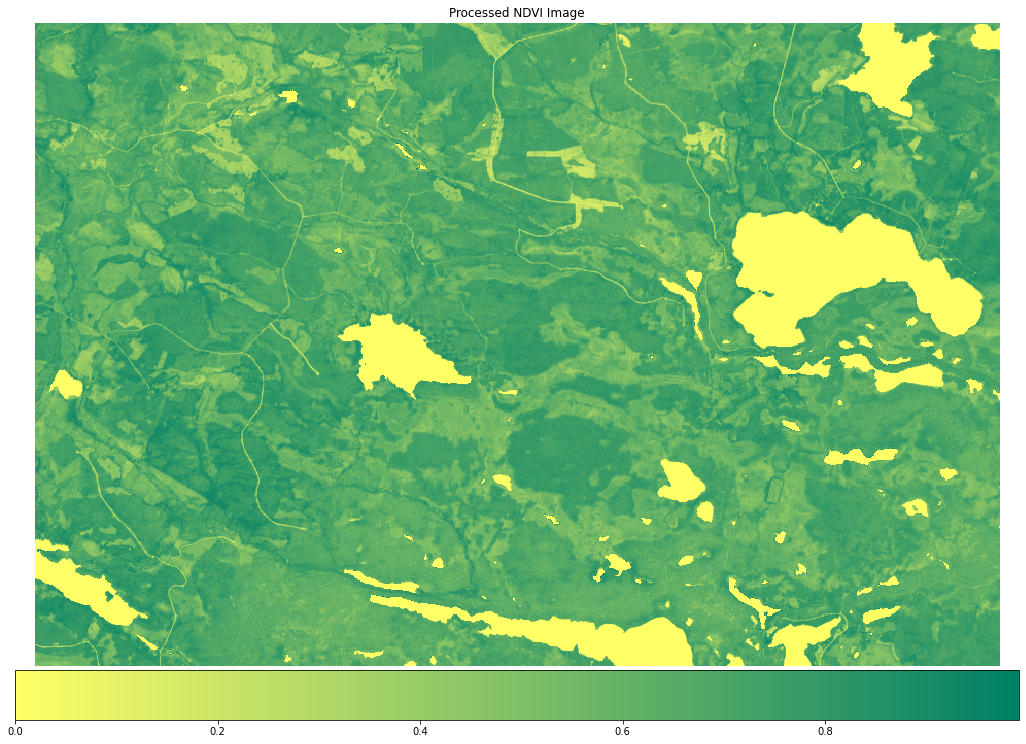

In [18]:
im = np.clip((ndvi_norm - water_mask), a_min=0, a_max=1, dtype=np.float64)

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(18, 14))

implot = ax0.imshow(im, interpolation='none', cmap=cm.summer_r)
_ = ax0.set_title('Processed NDVI Image')
_ = ax0.axis('off')
_ = fig.colorbar(implot, orientation='horizontal', pad=0.005)

To ease the segementation task, more image processing is performed to enhance contrast between forest and non-forest areas. Histogram analysis is used to guide the process. From the first histogram, it is posssible to observe a relevant groupping of pixels intensities in the range (approximately) [125,225]. Therefore, Gamma-transformation is applied to stretch the lighter regions of the input image (or to compress the darker regions). To further enhance contrast, Contrast Limited Adaptive Histogram Equalization (CLAHE) is applied. The output is an image where pixels' intensity are nicely spread, well distributed over a large range of the histogram.

In [19]:
def gamma_transf(im, gamma):
    lookUpTable = np.empty(shape=(1,256), dtype=np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(np.power(i / 255.0, gamma) * 255.0, 0, 255) # Gamma transformation formula
    return cv.LUT(im, lookUpTable) # Look-up table transform of the image

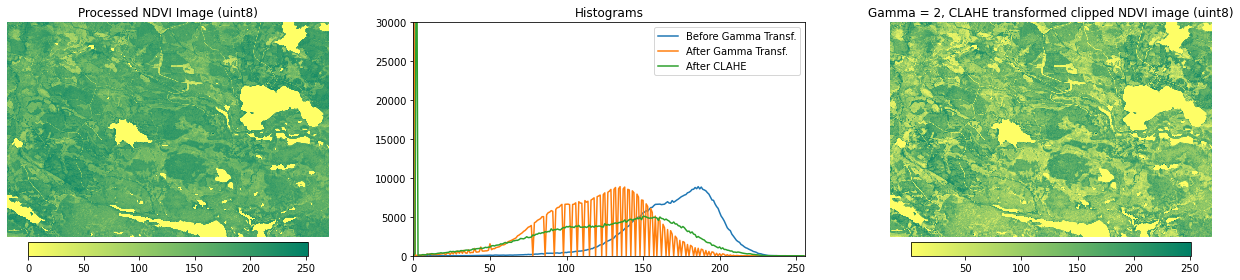

In [20]:
im_uint8 = (im*255).astype(np.uint8)
im_gamma2 = gamma_transf(im_uint8, gamma=2)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

implot = ax0.imshow(im_uint8, interpolation='none', cmap=cm.summer_r)
_ = ax0.set_title('Processed NDVI Image (uint8)')
_ = ax0.axis('off')
_ = fig.colorbar(implot, ax=ax0, fraction=0.06, orientation='horizontal', pad=0.02)

hist = cv.calcHist(images=[im_uint8], channels=[0], mask=None, histSize=[256], ranges=[0,256])
_ = ax1.plot(hist, label='Before Gamma Transf.')

hist_gamma = cv.calcHist(images=[im_gamma2], channels=[0], mask=None, histSize=[256], ranges=[0,256])
_ = ax1.plot(hist_gamma, label='After Gamma Transf.')

dim_ratio = im_gamma2.shape[1] / im_gamma2.shape[0]
clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(8,int(np.floor(10*dim_ratio))))
clahe_im = clahe.apply(im_gamma2)
hist_clahe = cv.calcHist(images=[clahe_im], channels=[0], mask=None, histSize=[256], ranges=[0,256])
_ = ax1.plot(hist_clahe, label='After CLAHE')

_ = ax1.set_title('Histograms')
_ = ax1.set_xlim([0,256])
_ = ax1.set_ylim([0,30000])
_ = ax1.legend()

implot = ax2.imshow(clahe_im, interpolation='none', cmap=cm.summer_r)
_ = ax2.set_title('Gamma = 2, CLAHE transformed clipped NDVI image (uint8)')
_ = ax2.axis('off')
_ = fig.colorbar(implot, ax=ax2, fraction=0.06, orientation='horizontal', pad=0.02)

plt.tight_layout()

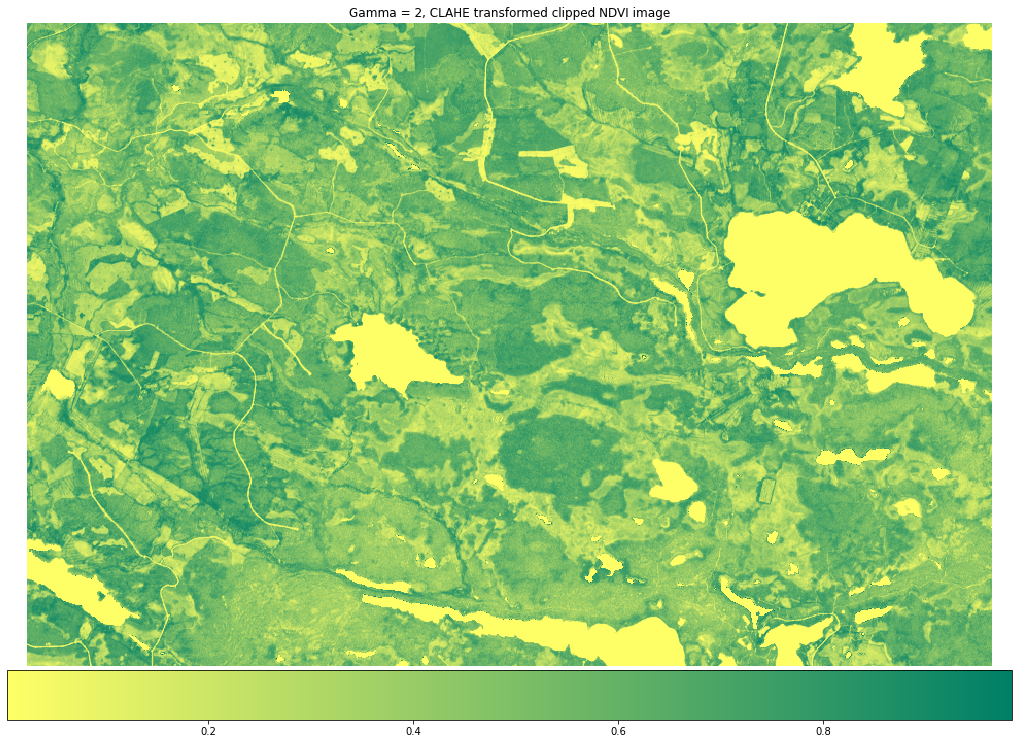

In [21]:
im = clahe_im.astype(np.float64) / 255.0
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(18, 14))

implot = ax0.imshow(im, interpolation='none', cmap=cm.summer_r)
_ = ax0.set_title('Gamma = 2, CLAHE transformed clipped NDVI image')
_ = ax0.axis('off')
_ = fig.colorbar(implot, orientation='horizontal', pad=0.005)

### Segmentation 1: Thresholding

The first segmentation approach is to threshold the image produced by the processing pipeline. The thresholding values are computed by simply dividing the intensity range [0,1] into equally-spaced intervals depending on the number of classes to be identified.

In [22]:
def equallySpaced_threshold(image, n_classes):
    threshold_values = np.linspace(start=0.0, stop=1.0, num=n_classes+1, dtype=np.float64)
    class_values = np.linspace(start=0, stop=1, num=n_classes, dtype=np.float64)
    segmented_im = np.zeros(shape=(image.shape))
    for i in range(len(class_values)):
        segmented_im[threshold_values[i] < image] = class_values[i]
    return segmented_im

A loop is implemented to perform segmentation for a different number of classes and plot the obtained results.

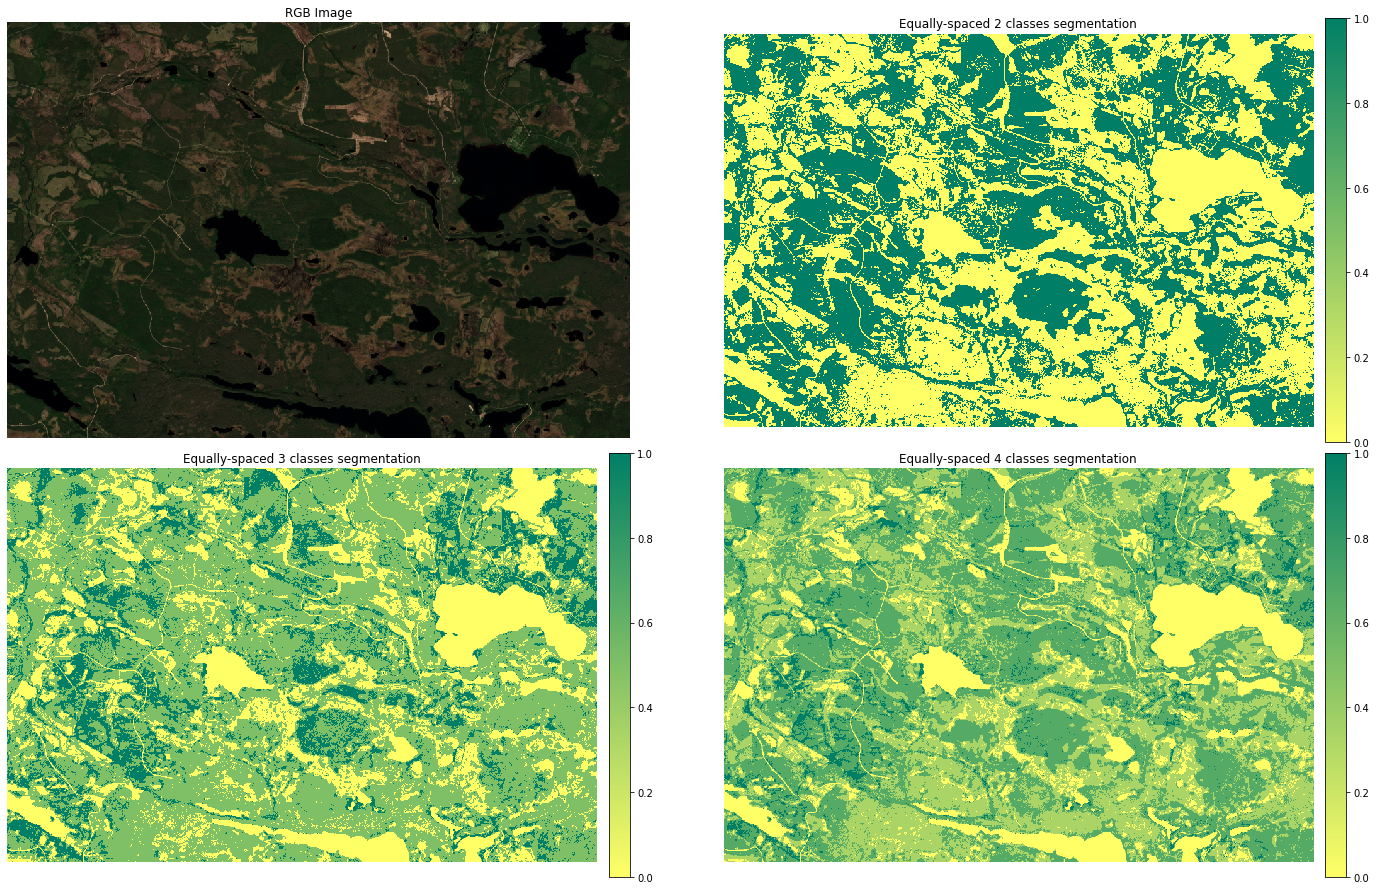

In [23]:
n_classes = 4

nrows=int(np.ceil(n_classes/2))
fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(24, 8*nrows))

implot0 = axs.flat[0].imshow(np.clip(data[:,:, (3,2,1)]*3.5, a_min=0, a_max=1), interpolation='none')
_ = axs.flat[0].set_title('RGB Image')
_ = axs.flat[0].axis('off')


pos = 1
for n_classes in range(2, n_classes+1):

    segmented_im = equallySpaced_threshold(image=im, n_classes=n_classes)

    implot1 = axs.flat[pos].imshow(segmented_im, interpolation='none', cmap=cm.summer_r)
    _ = axs.flat[pos].set_title(f'Equally-spaced {n_classes} classes segmentation')
    _ = axs.flat[pos].axis('off')
    _ = fig.colorbar(implot1, ax=axs.flat[pos], fraction=0.034, orientation='vertical', pad=0.02)

    pos += 1

if n_classes % 2 != 0:
    plt.delaxes(axs.flat[pos])
plt.subplots_adjust(wspace=0.15, hspace=0.)

Comparing the original image (RGB) with the result obtained for 2-classes (forest and non-forest) segmentation, it is possible to observe that the model performed reasonably well. Water regions, roads, possible rocky terrain and very low vegetation density areas are identified as non-forest, and areas of high vegetation density are identified as forest. The segmentation of areas with medium vegetation density can have high uncertainty.

As the number of classes increases (e.g., 3-classes and 4-classes segmentations), it is possible to observe that the segmentation results remain satisfactory while becoming more fine-grained, making it possible to specifically pin point areas that were previously groupped together and to reason about areas with different vegetation density levels (e.g., young and mature forests).

### Segmentation 2: Supervised Learning

Although the results obtained with thresholding segmentation seem satisfactory, information from different bands are not used in that analysis. Therefore, to assess whether including such information could potentially produce more accurate results, a rather simple approach with supervised learning is experimented. To generate labeled data for training the model, the following idea was implemented:

1. Use the image outputted by the processing pipeline and the same equally-spaced thresholding approach to define classes
2. Compute the mean intensity value for each class 
3. Create labels only for those pixels which corresponding intesity value are within a (user-defined) small interval around its class mean (not the standard deviation)

The key idea is that not all pixels within the thresholding boundaries are labeled, but only those that are situated around the class mean. In this way, I understand the chance of mislabelling a data point is reduced.

In [24]:
col_names = copy.deepcopy(bands)
col_names.append('Class')

df_im = pd.DataFrame(columns=col_names)

In [25]:
n_classes = 2

labels = np.zeros(shape=(im.shape[0], im.shape[1], n_classes), dtype=np.uint8)
threshold_values = np.linspace(start=0.0, stop=1.0, num=n_classes+1, dtype=np.float64)
for i in range(0, n_classes):
    tmp = copy.deepcopy(im)
    interval_dist = threshold_values[i+1]-threshold_values[i]
    tmp[im > threshold_values[i+1]] = 0
    tmp[im < threshold_values[i]] = 0
    class_mean = np.nanmean(np.where(np.isclose(tmp,0), np.nan, tmp))
    labels[:,:,i][im < (class_mean + (0.15*interval_dist))] = 1
    labels[:,:,i][im < (class_mean - (0.15*interval_dist))] = 0

rng = np.random.default_rng()

for a_class in range(n_classes):
    x_allCoord, y_allCoord = np.nonzero(labels[:,:,a_class])
    coords = np.array([x_allCoord, y_allCoord]).T
    coords = rng.permutation(coords, axis=0)
    coords = coords[0:int(np.floor(0.1*im.shape[0]*im.shape[1]/n_classes)),:]
    features = data[coords[:,0], coords[:,1], :-1]
    ndvi_feature = im[coords[:,0], coords[:,1]].reshape(coords.shape[0], 1)
    labels_tmp = np.full(shape=(coords.shape[0],1), fill_value=a_class, dtype=np.float64)
    col_values = np.hstack([features, ndvi_feature, labels_tmp])
    
    df = pd.DataFrame(col_values, columns=col_names)
    df_im = df_im.append(df)

In [26]:
df_im.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58562 entries, 0 to 29280
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   B01     58562 non-null  float64
 1   B02     58562 non-null  float64
 2   B03     58562 non-null  float64
 3   B04     58562 non-null  float64
 4   B05     58562 non-null  float64
 5   B06     58562 non-null  float64
 6   B07     58562 non-null  float64
 7   B08     58562 non-null  float64
 8   B8A     58562 non-null  float64
 9   B09     58562 non-null  float64
 10  B11     58562 non-null  float64
 11  B12     58562 non-null  float64
 12  NDVI    58562 non-null  float64
 13  Class   58562 non-null  float64
dtypes: float64(14)
memory usage: 6.7 MB


The labeled data is split into training and testing datasets, as usual. However, as the intra-class correlation among data points is high (only pixels with intensity values around the class mean were chosen), validating the model using these datasets dataset produces over-optimistic results. Therefore, most of the data is allocated for training.

In [27]:
trainIndex = np.random.choice(df_im.shape[0], size=int(np.floor(0.9*df_im.shape[0])), replace=False)
train_dataset = df_im.iloc[trainIndex]
test_dataset = df_im.iloc[~df_im.index.isin(trainIndex)]

train_x, train_y = train_dataset.drop(columns=['Class'], inplace=False), train_dataset['Class']
test_x, test_y = test_dataset.drop(columns=['Class'], inplace=False), test_dataset['Class']

In [28]:
classifier = RandomForestClassifier(n_estimators=50, max_features='auto', max_samples=0.7, max_depth=20, oob_score=False)

In [29]:
scores = cross_val_score(classifier, train_x.values, train_y.values, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

_ = classifier.fit(train_x.values, train_y.values)

1.00 accuracy with a standard deviation of 0.00


In [30]:
df_data = pd.DataFrame(columns=bands)

features = data[:,:,:-1]
ndvi_feature = np.expand_dims(im[:,:],axis=2)
col_values = np.dstack([features, ndvi_feature])
col_values = col_values.reshape(col_values.shape[0]*col_values.shape[1],-1)

df = pd.DataFrame(col_values, columns=bands)
df_data = df_data.append(df)

df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585625 entries, 0 to 585624
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   B01     585625 non-null  float64
 1   B02     585625 non-null  float64
 2   B03     585625 non-null  float64
 3   B04     585625 non-null  float64
 4   B05     585625 non-null  float64
 5   B06     585625 non-null  float64
 6   B07     585625 non-null  float64
 7   B08     585625 non-null  float64
 8   B8A     585625 non-null  float64
 9   B09     585625 non-null  float64
 10  B11     585625 non-null  float64
 11  B12     585625 non-null  float64
 12  NDVI    585625 non-null  float64
dtypes: float64(13)
memory usage: 62.6 MB


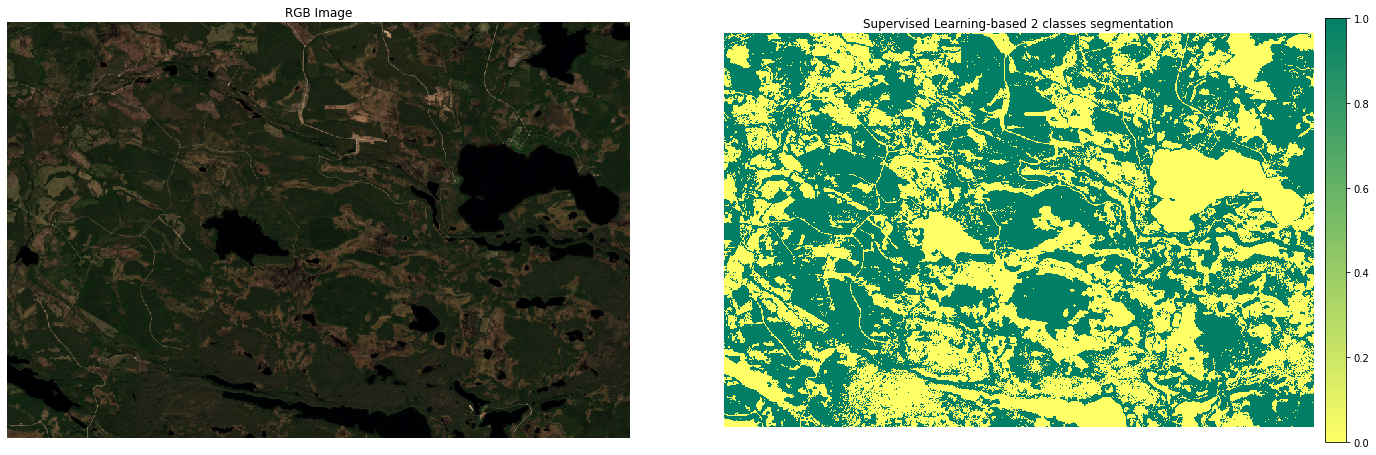

In [31]:
segmented_im = classifier.predict(df_data.values).reshape(data.shape[:-1])
file_path = data_folder + 'labels.npy'
np.save(file_path, segmented_im)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 16))

implot0 = axs.flat[0].imshow(np.clip(data[:,:, (3,2,1)]*3.5, a_min=0, a_max=1), interpolation='none')
_ = axs.flat[0].set_title('RGB Image')
_ = axs.flat[0].axis('off')

implot1 = axs.flat[1].imshow(segmented_im, interpolation='none', cmap=cm.summer_r)
_ = axs.flat[1].set_title(f'Supervised Learning-based {n_classes} classes segmentation')
_ = axs.flat[1].axis('off')
_ = fig.colorbar(implot1, ax=axs.flat[1], fraction=0.034, orientation='vertical', pad=0.02)

plt.subplots_adjust(wspace=0.15, hspace=0.)

Again, comparing the original image (RGB) with the result obtained for 2-classes (forest and non-forest) segmentation, it seems that the model learned reasonably well the characteristics of each class and was able to correctly classify (most) of the data.

### Validation

If ground truth data was available, a more quantitative validation could be performed. In this case, my to-go approach would be to create a Confusion Matrix where different metrics could be analysed. For example, if it is more important for CollectiveCrunch to correctly identify all forest pixels at the cost of misclassifying some non-forest pixels, the Confusion Matrix can offer valuable insights on how to tune parameters (e.g., thresholding values). Moreover, the ROC Area Under Curve (AUC) could be used to compare the different solutions (i.e., models) to the same problem. In addition, the Sørensen–Dice coefficient could be computed to assess the similarity between the ground truth and the segmentation results. However, as ground truth data is not available, a more qualitative approach is taken.

#### Comparing Segmentation Results

In this section, the segmentation results (number of classes = 2) produced by both the thresholding and supervised learning models are compared.  

In [32]:
thres_im = equallySpaced_threshold(image=im, n_classes=2)
sl_im = segmented_im
diff_im = np.abs(sl_im - thres_im)

diff = np.count_nonzero(diff_im) / (diff_im.shape[0] * diff_im.shape[1])
print(f'Difference ratio in comparison to the total number of pixels: {diff:.4f}')

Difference ratio in comparison to the total number of pixels: 0.0657


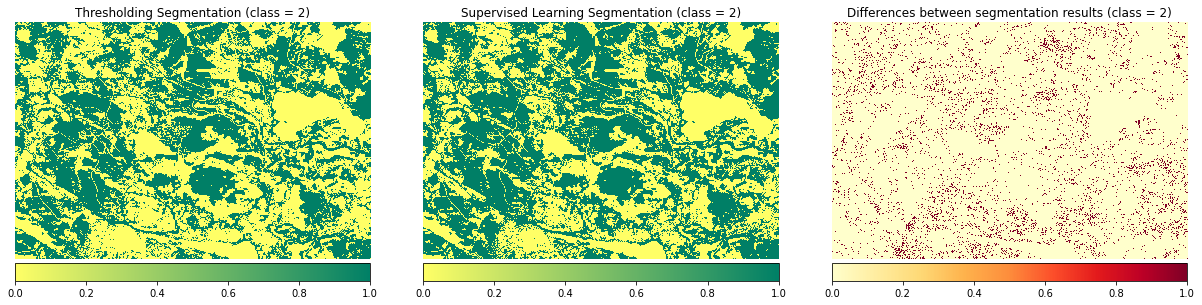

In [33]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(21, 14))

implot0 = ax0.imshow(thres_im, interpolation='none', cmap=cm.summer_r)
_ = ax0.set_title('Thresholding Segmentation (class = 2)')
_ = ax0.axis('off')
_ = fig.colorbar(implot0, ax=ax0, orientation='horizontal', pad=0.005)

implot1 = ax1.imshow(sl_im, interpolation='none', cmap=cm.summer_r)
_ = ax1.set_title('Supervised Learning Segmentation (class = 2)')
_ = ax1.axis('off')
_ = fig.colorbar(implot1, ax=ax1, orientation='horizontal', pad=0.005)

implot2 = ax2.imshow(np.clip(data[:,:, (3,2,1)]*3.5, a_min=0, a_max=1), interpolation='none')
implot2 = ax2.imshow(diff_im, interpolation='none', cmap=cm.YlOrRd)
_ = ax2.set_title('Differences between segmentation results (class = 2)')
_ = ax2.axis('off')
_ = fig.colorbar(implot2, ax=ax2, orientation='horizontal', pad=0.005)

plt.subplots_adjust(wspace=0.15, hspace=0.)

It is reasonable to think that most of this difference (approx. 6.6%) comes from data points that are in thresholding 'grey zones' (i.e., areas of high uncertainty near the thresholding boundaries), such as an area with medium vegetation density. The thresholding segmentation model has rigid boundaries while the supervised learning model has more flexibility by learning from data. Taking into account that data points sitting in the middle of the thresholding boundary intervals (or far from the 'grey zones') should be well classified by both models, one can argue that the achieved overall 2-classes segmentation accuracy should be reasonably high. The choice of model would depend on a trade-off between speed (the thresholding segmentation model is much faster) and accuracy (supposing the supervised learning model can outperform its par). 

### Further Ideas

When considering what methods to use for solving this task, other alternative approaches and additional tools came to my mind as reasonable options. Some of them could potentially replace (parts of) the developed work whereas others could be be added on to some point of the analysis pipeline. These approaches and tools could turn out to be useful and potentially produce good segmentation results. Some ideas are:

- Stack additional domain-related indices
- Use automatic multiple thresholding
- Segment using clustering (unsupervised learning)
- Label data with Gaussian Mixture Models (semi-supervised learning): quite promising if considering that intra-class physical properties should be normally distributed. More exploration would be required to ensure this technique could work, as I do not have a vast expertise with it

## Task: Forest Disturbances

### Solution Outline

1. Filter out unusable images: account for could percentage using the Statiscal Info Service (FIS) and for snow percentage evaluating pixel values in suitable band(s)/indices. A simpler approach could be to compute the ratio of white pixels (i.e., high reflectance values) in the RGB channel in comparison to the total number of image pixels
2. Compute domain-related indices (e.g., NDVI, leaf area, bare soil and burn ratio) and stack them onto the image data
3. Create preliminary areas of interest (aoi) mask: For each pixel, create a intensity value time-series on each of the available bands (and stacked indices). If no disturbance has occurred, intensity values should be quite stable throughout the series (possibly harmonic to account for the different seasons of the year). A preliminary mask can be created by identifying pixels with large intensity variations in the series. An alternate, cheaper approach to delineate such areas of disturbance would be to check the difference (i.e., subtraction) between the first image and the last image of the desired period (in all bands and stacked indices). However, this approach should not detect disturbed areas that have recovered to a condition similar to the one in beginning of the period
4. Create forest disturbance mask: using NDVI or other vegetation-enhancing index, identify which of the preliminary aio correspond to actual forest areas (a threshold value could be set based on domain knowledge about the forest characteristics in the area)
5. Predict time (i.e. month) of disturbance: If the cheaper approach was chosen, create the intensity value time-series only for those pixels in the forest disturbance mask; else, the time-series already exists for all pixels. Use statistics to extract information about the behaviour of sentinel bands (e.g., moving average, max, min, mean, sd) in the different dates of image acquisitions. Predict the most likely time of disturbances based on large variations of such measurements (or by visually inspecting them)
6. Classify disturbances into unique classes: based on the bands (and indices) that reacted the most to the disturbances and their behaviour, group these disturbances into unique classes (e.g., pixels' value in the burn ratio channel increases after fires and pixels' value in the NDVI channel increases after forest growth)

### Potential Challenges

- Variations caused by solar illumination, atmospheric conditions and viewing geometry differences
- Sparse image acquisitions after filtering out images unusable images
- Setting a forest threshold
- Simultaneous disturbances in the same area (e.g., tree parasite insect attack together with wind damage)